<div class="alert alert-success">
    <center> <h1> <font size="8"> Multivariate Normal Example </font> </h1> </center>
    <center> <h1> <font size="5"> Cholesky Decomposition of Covariance Matrix $\Sigma$  </font> </h1> </center>
</div>

<br/>
<br/>

In this example, we model and predict all parameters of a trivariate ($Y_{D}=3$) Normal distribution. The conditional means $\mathbf{\mu}(x) \in \mathbb{R}^{D}$ and the conditional covariance matrix $\mathbf{\Sigma}(x) \in \mathbb{R}^{D \times D}$ are given as follows

$$
\mathbf{\mu}(x)=\begin{pmatrix}\mu_{1}(x) \\ \mu_{2}(x) \\ \mu_{3}(x)\end{pmatrix}, \qquad \qquad  
\mathbf{\Sigma}(x)= \begin{pmatrix}
\sigma^{2}_{11}(x) & \rho_{1,2}(x)\sigma_{1}(x)\sigma_{2}(x) & \rho_{1,3}(x)\sigma_{1}(x)\sigma_{3}(x) \\
\rho_{2,1}(x)\sigma_{2}(x)\sigma_{1}(x) & \sigma^{2}_{22}(x) & \rho_{2,3}(x)\sigma_{2}(x)\sigma_{3}(x) \\
\rho_{3,1}(x)\sigma_{3}(x)\sigma_{1}(x) & \rho_{3,2}(x)\sigma_{3}(x)\sigma_{2}(x) &  \sigma^{2}_{33}(x)
\end{pmatrix}
$$

To ensure positive definiteness of $\Sigma(\cdot)$, the $D(D + 1)/2$ entries of the covariance matrix must satisfy specific conditions. For the bivariate case, this can be ensured by applying exponential functions to the variances and a suitable transformation to restrict the coefficient of correlation $\rho \in [-1,1]$. However, in high-dimensional settings, where all moments are modelled as functions of covariates, ensuring positive definiteness of the covariance matrix becomes challenging, since joint restrictions for the elements are necessary. A computationally more tractable approach to ensure positive definiteness is based on the Cholesky decomposition, that uniquely decomposes the covariance matrix as follows

$$
\mathbf{\Sigma}(x) = \mathbf{L}(x) \mathbf{L}^{\prime}(x)
$$

where $\mathbf{L}(\cdot) \in \mathbb{R}^{D \times D}$ is a lower triangular matrix. To ensure $\mathbf{\Sigma}(\cdot)$ to be positive definite, the $D$ diagonal elements $\ell_{ii}$ of
$\mathbf{L}(\cdot)$ need to be strictly positive, whereas all $D(D −1)/2$ off diagonal elements $\ell_{ij}$ can take on any value. For the trivariate case, the Cholesky factor $\mathbf{L}(\cdot)$ is given as follows

$$
\mathbf{L}(x)= \begin{pmatrix}
\exp\big(\ell_{11}(x)\big) & 0 & 0 \\
\ell_{21}(x) & \exp\big(\ell_{22}(x)\big) & 0 \\
\ell_{31}(x) & \ell_{32}(x) & \exp\big(\ell_{33}(x)\big)\\
\end{pmatrix}
$$

Given the usefulness of the Cholesky decomposition, instead of estimating the entries of $\mathbf{\Sigma}(\cdot)$ directly, Py-BoostLSS estimates the Cholesky factors $\mathbf{L}(\cdot)$ and then uses these for creating $\mathbf{\Sigma}(\cdot)$. However, in contrast to the original formulation of $\mathbf{\Sigma}(\cdot)$, the elements in $\mathbf{L}(\cdot)$ do not have any direct interpretation. For more details, we refer to our related paper **[März, Alexander (2022), *Multi-Target XGBoostLSS Regression*](https://arxiv.org/abs/2210.06831)**.

<br/>
<br/>

# Imports

In [1]:
import os
import numpy as np
import pandas as pd
# Optional: set the device to run
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from pyboostlss.model import *
from pyboostlss.distributions.MVN import *
from pyboostlss.distributions.distribution_loss_metric import *
from pyboostlss.utils import *
from pyboostlss.datasets.data_loader import load_example_data

import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

# Specifiy distribution and initialize model

In [2]:
distribution = MVN(D=3)           # Multivariate Normal distribution, where D specifies the number of target variables
pyblss = PyBoostLSS(distribution) # Initializes model with specified distribution

# Data

In [3]:
data_sim = load_example_data("sim_triv_gaussian.csv")

# Create 60%, 20%, 20% split for train, validation and test 
train, validate, test = np.split(data_sim.sample(frac=1,random_state=123), [int(0.6*len(data_sim)), int(0.8*len(data_sim))])

# Train
x_train = train["x"].values.reshape(-1,1)
y_train = train.filter(regex="y").values
dtrain = {"X": x_train, "y": y_train}

# Validation
x_eval = validate["x"].values.reshape(-1,1)
y_eval = validate.filter(regex="y").values
eval_sets = [{'X': x_eval, 'y': y_eval}] # Specifies eval_sets on which the model is evaluated on

# Test
x_test = test["x"].values.reshape(-1,1)
y_test = test.filter(regex="y").values

# Hyper-Parameter Optimization via Optuna

In [4]:
np.random.seed(123)

# Specifies the hyper-parameters and their value range
    # The structure is as follows: "hyper-parameter": [lower_bound, upper_bound]
    # Currently, only the following hyper-parameters can be optimized
    
hp_dict = {"lr": [1e-3, 1],  
           "max_depth": [1, 4],
           "sketch_outputs": [1,10],
           "lambda_l2": [0, 40],     
           "colsample": [0.2, 1.0],
           "subsample": [0.2, 1.0],
           "min_gain_to_split": [0, 500]
          }  

opt_param = pyblss.hyper_opt(params=hp_dict,
                             dtrain=dtrain,
                             eval_sets=eval_sets,
                             use_hess=True, 
                             sketch_method="proj",
                             hp_seed=123,                # Seed for random number generator used in the Bayesian hyper-parameter search.
                             ntrees=500,                 # Number of boosting iterations.
                             es=20,                      # Early stopping rounds
                             n_trials=50,                # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             max_minutes=120,            # Time budget in minutes, i.e., stop study after the given number of minutes.
                             silence=False)              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.

[I 2022-12-08 10:30:39,457] A new study created in memory with name: Py-BoostLSS Hyper-Parameter Optimization
C:\Users\Alexander\.julia\v0.6\Conda\deps\usr\envs\pyboost\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/50 [00:00<?, ?it/s]

[10:30:48] Stdout logging level is INFO.
[10:30:48] GDBT train starts. Max iter 500, early stopping rounds 20
[10:30:51] Iter 0; Sample 0, NLL-score = 8541.073205277175; 
[10:30:55] Early stopping at iter 49, best iter 29, best_score 7116.858480147423
[I 2022-12-08 10:30:55,540] Trial 0 finished with value: 7116.8583984375 and parameters: {'lr': 0.5954471338198504, 'max_depth': 4, 'sketch_outputs': 5, 'lambda_l2': 32.1564214078094, 'colsample': 0.9300723163380973, 'subsample': 0.9978986713204032, 'min_gain_to_split': 101.1832241713046}. Best is trial 0 with value: 7116.8583984375.
[10:30:55] Stdout logging level is INFO.
[10:30:55] GDBT train starts. Max iter 500, early stopping rounds 20
[10:30:55] Iter 0; Sample 0, NLL-score = 9137.092449214735; 
[10:31:17] Early stopping at iter 334, best iter 314, best_score 7070.342669061618
[I 2022-12-08 10:31:17,754] Trial 1 finished with value: 7070.3427734375 and parameters: {'lr': 0.36543993986762574, 'max_depth': 1, 'sketch_outputs': 8, 'lam

# Model Training

In [5]:
opt_params = opt_param.copy()

pyboostlss_model = pyblss.train(dtrain=dtrain,
                                lr=opt_params["lr"], 
                                lambda_l2=opt_params["lambda_l2"],
                                max_depth=opt_params["max_depth"],
                                sketch_outputs=opt_params["sketch_outputs"],
                                colsample=opt_params["colsample"],
                                subsample=opt_params["subsample"],
                                min_gain_to_split=opt_params["min_gain_to_split"],
                                ntrees=opt_params["opt_rounds"],
                                use_hess=True,
                                verbose=100,                                
                                sketch_method="proj",
                                seed=123)

[10:47:23] Stdout logging level is INFO.
[10:47:23] GDBT train starts. Max iter 295, early stopping rounds 100
[10:47:23] Iter 0; 
[10:47:30] Iter 100; 
[10:47:36] Iter 200; 
[10:47:43] Iter 294; 


# Predict

In [6]:
# Predicts transformed parameters of the specified distribution. Py-BoostLSS returns the elements of the covariance matrix, instead of the Cholesky factors.
predt_params = distribution.predict(model=pyboostlss_model,
                                    X_test=x_test,
                                    pred_type="parameters")
predt_params

,location_1,location_2,location_3,scale_1,scale_2,scale_3,rho_21,rho_31,rho_32
0,0.238509,1.158969,0.900038,0.625202,1.585090,1.249630,0.739256,0.285021,0.708058
1,-0.190312,0.455509,1.469211,0.681548,1.831757,1.762837,0.908357,0.650705,0.588464
2,0.507264,0.546566,1.805552,0.949186,1.715602,1.011171,0.680754,0.694708,0.433671
3,0.365436,0.527660,1.643498,0.890845,1.382306,1.031593,0.906858,0.670710,0.461449
4,0.129035,0.740134,1.840273,0.794982,1.694562,1.409752,0.786281,0.712894,0.532611
...,...,...,...,...,...,...,...,...,...
1995,0.060102,0.077928,1.000422,0.625758,1.061979,1.150634,0.916143,0.540373,0.711049
1996,-0.190837,0.459812,1.493580,0.683055,1.823536,1.765891,0.909506,0.640304,0.577827
1997,0.507264,0.546566,1.805552,0.949186,1.715602,1.011171,0.680754,0.694708,0.433671
1998,0.121481,1.315664,0.958999,0.605198,1.582975,1.265084,0.746560,0.303109,0.699813


In [7]:
# Draws random samples from the predicted distribution
torch.manual_seed(123)
n_samples = 10000
predt_samples = distribution.predict(model=pyboostlss_model,
                                     X_test=x_test,
                                     pred_type="samples",   
                                     n_samples=n_samples)

predt_samples.shape # Output-shape is (n_samples, n_obs, n_target)

(10000, 2000, 3)

# Plots

## Actual vs. Predicted Parameters

In the following figure, we compare the true parameters of the multivariate Gaussian with the ones predicted by Py-BoostLSS. The below figure shows that the estimated parameters of the multivariate Gaussian closely match the true parameters.

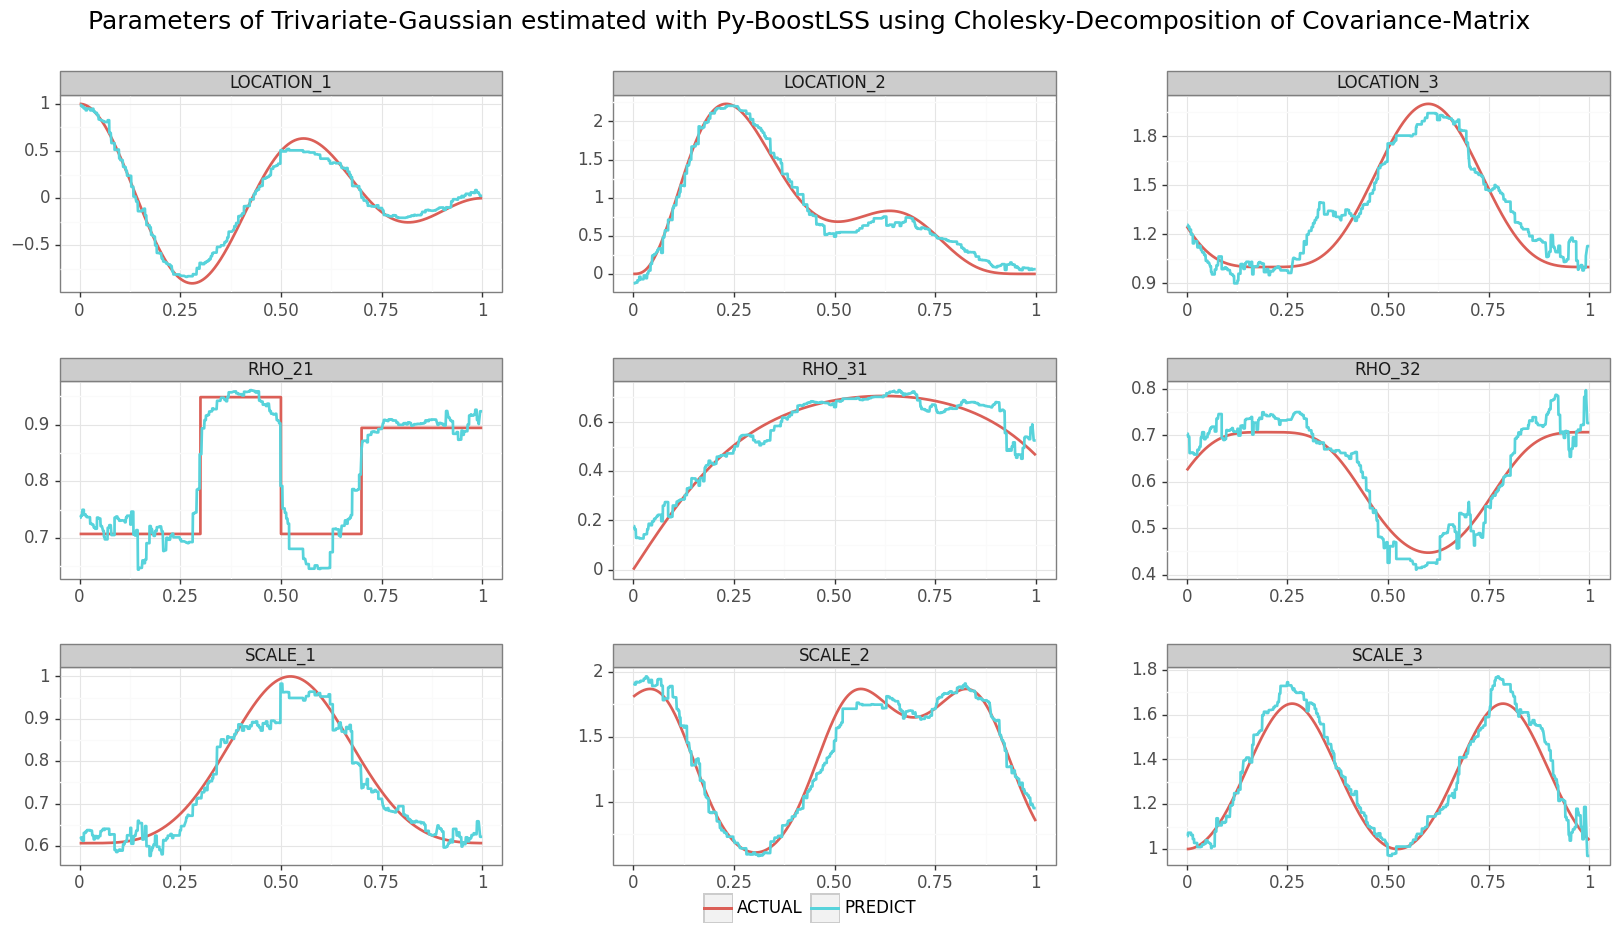

In [8]:
predt_params["x"] = x_test
dist_params = list(predt_params.columns)
drop_cols = [resp for resp in list(test.columns) if "y" in resp]

# Data with actual values
plot_df_actual = pd.melt(test.drop(columns=drop_cols, axis=0),
                         id_vars="x",
                         value_vars=dist_params)
plot_df_actual["type"] = "ACTUAL"

# Data with predicted values
plot_df_predt = pd.melt(predt_params,
                        id_vars="x",
                        value_vars=dist_params)
plot_df_predt["type"] = "PREDICT"

plot_df = pd.concat([plot_df_actual, plot_df_predt])   

plot_df["variable"] = plot_df.variable.str.upper()


plot_params = (ggplot(plot_df,
                      aes(x="x",
                          y="value",
                          color="type")) +
               geom_line(size=1.1) + 
               facet_wrap("variable",
                          scales="free") + 
               labs(title="Parameters of Trivariate-Gaussian estimated with Py-BoostLSS using Cholesky-Decomposition of Covariance-Matrix\n",
                    x="",
                    y="") + 
               theme_bw(base_size=15) + 
               theme(legend_position="bottom",
                     legend_title = element_blank(),
                     subplots_adjust={"wspace": 0.25,
                                      "hspace": 0.45})
              )


print(plot_params)

## Actuals vs. Predicted

Since we predict the entire conditional distribution, we can overlay the point predictions with predicted densities, from which we can also derive quantiles of interest.

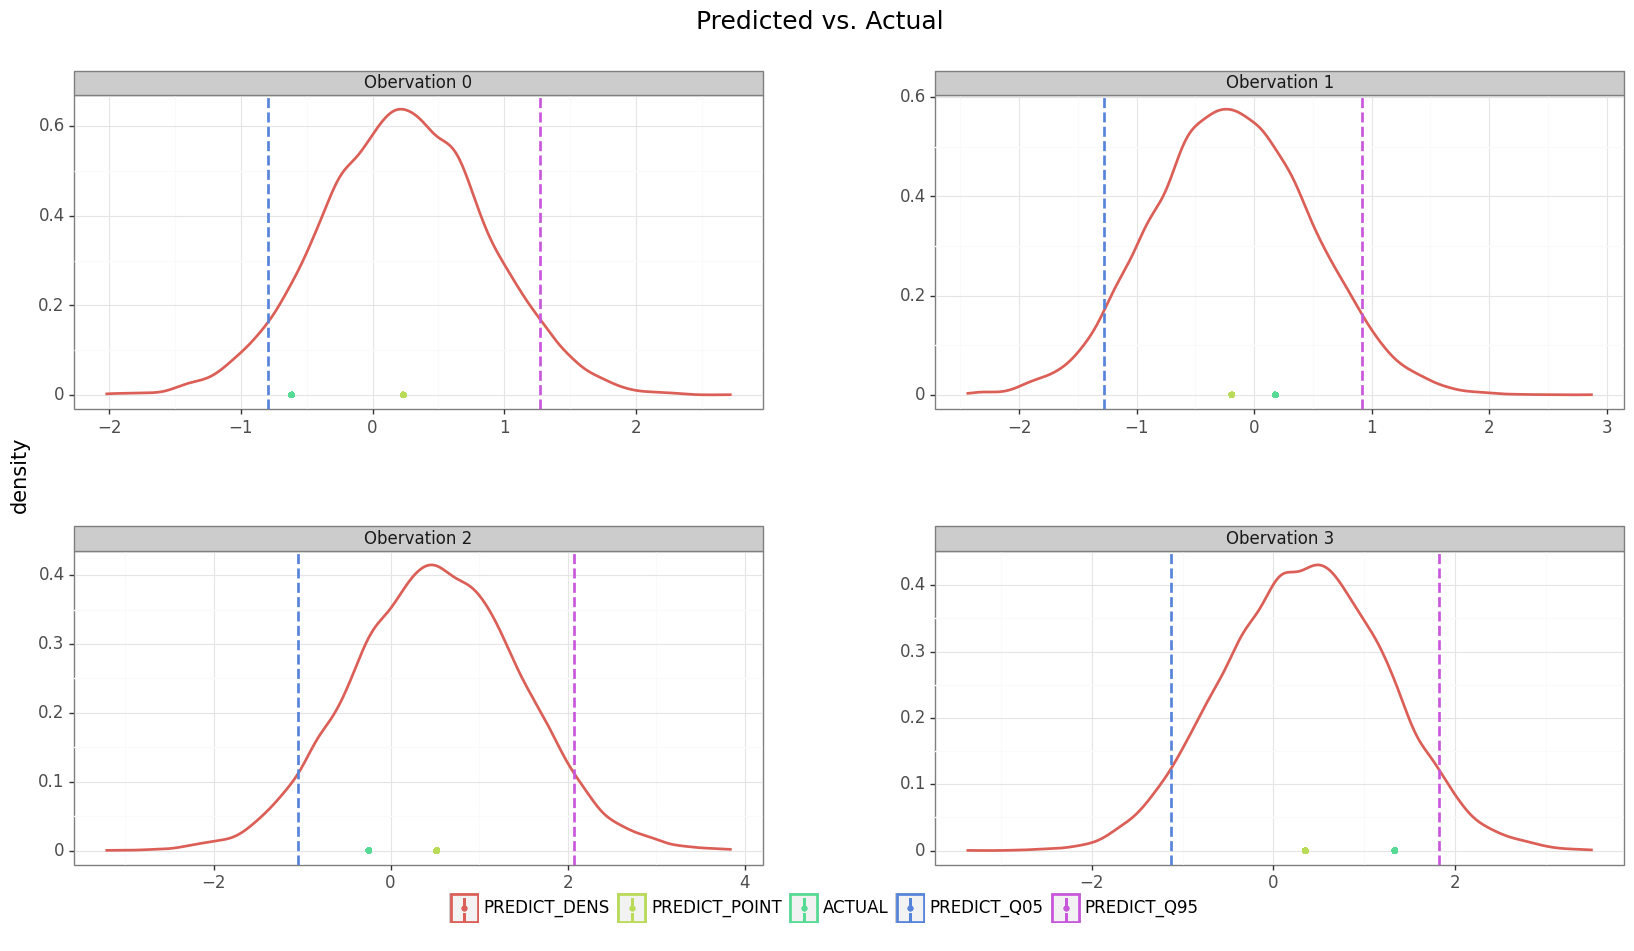

In [10]:
y_pred = []

n_examples = 4
q_sel = [0.05, 0.95]

for i in range(n_examples):
    
    y_samples = pd.DataFrame(predt_samples[:,i,0].reshape(-1,1), columns=["PREDICT_DENS"])
    y_samples["PREDICT_POINT"] = y_samples["PREDICT_DENS"].mean()
    y_samples["PREDICT_Q05"] = y_samples["PREDICT_DENS"].quantile(q=q_sel[0])
    y_samples["PREDICT_Q95"] = y_samples["PREDICT_DENS"].quantile(q=q_sel[1])
    y_samples["ACTUAL"] = y_test[i,0]
    y_samples["obs"]= f"Obervation {i}"
    y_pred.append(y_samples)
    
pred_df = pd.melt(pd.concat(y_pred, axis=0), id_vars="obs")
df_actual, df_pred_dens, df_pred_point, df_q05, df_q95 = [x for _, x in pred_df.groupby("variable")]

plot_pred = (
    ggplot(pred_df,
           aes(color="variable")) + 
    stat_density(df_pred_dens,
                 aes(x="value"),
                 size=1.1) + 
    geom_point(df_pred_point,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_point(df_actual,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_vline(df_q05, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    geom_vline(df_q95, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    facet_wrap("obs",
               scales="free") + 
    labs(title="Predicted vs. Actual \n",
         x = "") + 
    theme_bw(base_size=15) +
    scale_fill_brewer(type="qual", palette="Dark2") + 
    theme(legend_position="bottom",
          legend_title = element_blank(),
          subplots_adjust={"wspace": 0.25,
                           "hspace": 0.45})
)

print(plot_pred)